<a href="https://colab.research.google.com/github/ugrani/experiments/blob/main/rnr_experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#get the dataset from hugging face
!pip install -q datasets

In [2]:
#load the dataset
from datasets import load_dataset

dataset = load_dataset(
    "ms_marco",
    "v1.1",
    split="validation"
)

print(dataset)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

v1.1/validation-00000-of-00001.parquet:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

v1.1/train-00000-of-00001.parquet:   0%|          | 0.00/175M [00:00<?, ?B/s]

v1.1/test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

Generating validation split:   0%|          | 0/10047 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/82326 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/9650 [00:00<?, ? examples/s]

Dataset({
    features: ['answers', 'passages', 'query', 'query_id', 'query_type', 'wellFormedAnswers'],
    num_rows: 10047
})


In [3]:
example = dataset[0]

print("Query:")
print(example["query"])

print("\nPassages (showing first 2):")
for p in example["passages"]["passage_text"]:
  print("-", p[:200], "...")

Query:
walgreens store sales average

Passages (showing first 2):
- The average Walgreens salary ranges from approximately $15,000 per year for Customer Service Associate / Cashier to $179,900 per year for District Manager. Average Walgreens hourly pay ranges from app ...
- The average revenue in 2011 of a Starbuck Store was $1,078,000, up  from $1,011,000 in 2010.    The average ticket (total purchase) at domestic Starbuck stores in  No … vember 2007 was reported at $6. ...
- In fiscal 2014, Walgreens opened a total of 184 new locations and acquired 84 locations, for a net decrease of 273 after relocations and closings. How big are your stores? The average size for a typic ...
- th store in 1984, reaching $4 billion in sales in 1987, and $5 billion two years later. Walgreens ended the 1980s with 1,484 stores, $5.3 billion in revenues and $154 million in profits. However, prof ...
- The number of Walgreen stores has risen from 5,000 in 2005 to more than 8,000 at present. The average sq

In [4]:
#subsample aggressively to control the GPU cost
import random

random.seed(42)

NUM_QUERIES = 200
TARGET_PASSAGES = 10_000
NUM_PASSAGES = 10_000

sampled_queries = random.sample(range(len(dataset)), NUM_QUERIES)

queries = []
relevant_passages = []
all_passages = []

for idx in sampled_queries:
    row = dataset[idx]
    queries.append(row["query"])

    for passage in row["passages"]["passage_text"]:
        all_passages.append(passage)

# Deduplicate and subsample passages
all_passages = list(set(all_passages))
all_passages = random.sample(
    all_passages,
    min(NUM_PASSAGES, len(all_passages))
)

print(f"Queries: {len(queries)}")
print(f"Passages: {len(all_passages)}")

# Start corpus with ALL passages from your sampled queries (so relevant ones are included)
corpus = set()
for idx in sampled_queries:
    row = dataset[idx]
    for p in row["passages"]["passage_text"]:
        corpus.add(p)

print("Initial corpus size (from sampled queries):", len(corpus))

# Add distractor passages from OTHER queries in validation split
all_indices = list(range(len(dataset)))
random.shuffle(all_indices)

for idx in all_indices:
    if idx in sampled_queries:
        continue
    row = dataset[idx]
    for p in row["passages"]["passage_text"]:
        corpus.add(p)
        if len(corpus) >= TARGET_PASSAGES:
            break
    if len(corpus) >= TARGET_PASSAGES:
        break

all_passages = list(corpus)
print("Final corpus size:", len(all_passages))


Queries: 200
Passages: 1648
Initial corpus size (from sampled queries): 1648
Final corpus size: 10000


In [5]:
#define the relevance
query_to_relevant = {}

for idx in sampled_queries:
    row = dataset[idx]
    query = row["query"]

    relevant = [
        p for p, is_rel in zip(
            row["passages"]["passage_text"],
            row["passages"]["is_selected"]
        )
        if is_rel == 1
    ]

    query_to_relevant[query] = relevant


In [6]:
!pip install -q sentence-transformers faiss-cpu


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.8/23.8 MB 111.1 MB/s eta 0:00:00


In [7]:
from sentence_transformers import SentenceTransformer
import numpy as np

model_name = "sentence-transformers/all-MiniLM-L6-v2"
model = SentenceTransformer(model_name)

# Encode passages
passage_emb = model.encode(
    all_passages,
    batch_size=128,
    show_progress_bar=True,
    convert_to_numpy=True,
    normalize_embeddings=True,   # important for cosine via dot product
)

print(passage_emb.shape)  # (num_passages, dim)


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/79 [00:00<?, ?it/s]

(10000, 384)


In [8]:
import faiss

dim = passage_emb.shape[1]
index = faiss.IndexFlatIP(dim)  # inner product; works with normalized embeddings as cosine
index.add(passage_emb)

print("FAISS ntotal:", index.ntotal)


FAISS ntotal: 10000


In [9]:
def retrieve(query, k=50):
    q_emb = model.encode(
        [query],
        convert_to_numpy=True,
        normalize_embeddings=True
    )
    scores, idxs = index.search(q_emb, k)
    return [all_passages[i] for i in idxs[0]], scores[0]


In [10]:
q = queries[0]
top, scores = retrieve(q, k=5)
print("Query:", q)
print("\nTop results:")
for i, p in enumerate(top, 1):
    print(f"\n#{i} (score={scores[i-1]:.3f})\n{p[:300]}...")


Query: what is a hypothyroidism test done for

Top results:

#1 (score=0.726)
TSH Testing. In diagnosing hypothyroidism, your doctor will take into account both your symptoms and the results of a thyroid stimulating hormone (TSH) test. In essence, hypothyroidism is the result of diminished levels of thyroid hormones—known as T3 and T4....

#2 (score=0.639)
Thyroid function tests are blood tests which help to check the function of the thyroid gland. They are mainly used to detect hypothyroidism (underactive thyroid) and hyperthyroidism (overactive thyroid). Note: the information below is a general guide only....

#3 (score=0.634)
Thyroid function test. A blood test measuring your hormone levels is the only accurate way to find out whether there's a problem. The test, called a thyroid function test, looks at levels of thyroid-stimulating hormone (TSH) and thyroxine (T4) in the blood....

#4 (score=0.609)
Thyroid hormone tests are blood tests that check how well the thyroid gland is worki

In [11]:
def recall_at_k(queries, query_to_relevant, k):
    hits = 0
    eligible = 0

    for q in queries:
        rels = query_to_relevant.get(q, [])
        if not rels:   # some queries may have 0 labeled relevant passages
            continue

        eligible += 1
        retrieved, _ = retrieve(q, k=k)
        retrieved_set = set(retrieved)

        # hit if ANY relevant passage appears in top-k
        if any(r in retrieved_set for r in rels):
            hits += 1

    return hits / eligible if eligible else 0.0, eligible

Ks = [10, 50, 100, 200]
for k in Ks:
    r, n = recall_at_k(queries, query_to_relevant, k)
    print(f"Recall@{k}: {r:.3f}  (evaluated on {n} queries)")


Recall@10: 0.979  (evaluated on 194 queries)
Recall@50: 0.995  (evaluated on 194 queries)
Recall@100: 1.000  (evaluated on 194 queries)
Recall@200: 1.000  (evaluated on 194 queries)


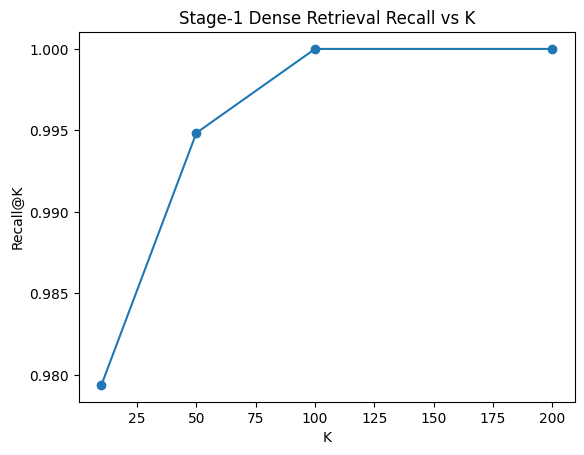

In [12]:
import matplotlib.pyplot as plt

recalls = []
for k in Ks:
    r, _ = recall_at_k(queries, query_to_relevant, k)
    recalls.append(r)

plt.figure()
plt.plot(Ks, recalls, marker="o")
plt.xlabel("K")
plt.ylabel("Recall@K")
plt.title("Stage-1 Dense Retrieval Recall vs K")
plt.show()


#next phas focusses on


Dense retriever gets top-K candidates

Cross-encoder scores (query, passage) pairs

Reorder candidates

Evaluate MRR@10 and NDCG@10 using your is_selected labels

In [ ]:
!pip install -q sentence-transformers


In [13]:
#load a strong MS MARCO cross-encoder
from sentence_transformers import CrossEncoder

reranker_name = "cross-encoder/ms-marco-MiniLM-L-6-v2"
reranker = CrossEncoder(reranker_name)


config.json:   0%|          | 0.00/794 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

In [14]:
#Build a query→relevant set in passage-text space
query_to_relevant_set = {q: set(rels) for q, rels in query_to_relevant.items()}


In [15]:
#Rerank function
import numpy as np

def rerank(query, candidates):
    pairs = [(query, p) for p in candidates]
    scores = reranker.predict(pairs)  # numpy array
    order = np.argsort(-scores)       # descending
    reranked = [candidates[i] for i in order]
    reranked_scores = scores[order]
    return reranked, reranked_scores


In [16]:
#Metrics: MRR@10 and NDCG@10
import math

def mrr_at_k(ranked_list, relevant_set, k=10):
    for i, p in enumerate(ranked_list[:k], start=1):
        if p in relevant_set:
            return 1.0 / i
    return 0.0

def ndcg_at_k(ranked_list, relevant_set, k=10):
    dcg = 0.0
    for i, p in enumerate(ranked_list[:k], start=1):
        rel = 1.0 if p in relevant_set else 0.0
        if rel > 0:
            dcg += rel / math.log2(i + 1)
    # Ideal DCG with binary rels: best case is 1 relevant at rank 1 (for our “any rel” framing)
    idcg = 1.0
    return dcg / idcg


In [17]:
#Evaluate: dense-only vs dense+rerank
def eval_ranking(queries, query_to_relevant_set, K_retrieve=50, K_eval=10, do_rerank=False):
    mrrs, ndcgs = [], []
    eligible = 0

    for q in queries:
        rels = query_to_relevant_set.get(q, set())
        if not rels:
            continue
        eligible += 1

        candidates, _ = retrieve(q, k=K_retrieve)  # dense top-K

        ranked = candidates
        if do_rerank:
            ranked, _ = rerank(q, candidates)

        mrrs.append(mrr_at_k(ranked, rels, k=K_eval))
        ndcgs.append(ndcg_at_k(ranked, rels, k=K_eval))

    return float(np.mean(mrrs)), float(np.mean(ndcgs)), eligible

K_retrieve = 50
mrr_dense, ndcg_dense, n = eval_ranking(queries, query_to_relevant_set, K_retrieve=K_retrieve, do_rerank=False)
mrr_rerank, ndcg_rerank, _ = eval_ranking(queries, query_to_relevant_set, K_retrieve=K_retrieve, do_rerank=True)

print(f"Evaluated on {n} queries, retrieve K={K_retrieve}")
print(f"Dense only   -> MRR@10: {mrr_dense:.4f}, NDCG@10: {ndcg_dense:.4f}")
print(f"+ Reranker   -> MRR@10: {mrr_rerank:.4f}, NDCG@10: {ndcg_rerank:.4f}")


Evaluated on 194 queries, retrieve K=50
Dense only   -> MRR@10: 0.5643, NDCG@10: 0.6890
+ Reranker   -> MRR@10: 0.6655, NDCG@10: 0.7743


In [18]:
# how K impacts reranker cost/quality

for K in [10, 20, 50, 100]:
    mrr_dense, ndcg_dense, n = eval_ranking(queries, query_to_relevant_set, K_retrieve=K, do_rerank=False)
    mrr_rerank, ndcg_rerank, _ = eval_ranking(queries, query_to_relevant_set, K_retrieve=K, do_rerank=True)
    print(f"K={K:>3} | Dense MRR@10 {mrr_dense:.4f} NDCG@10 {ndcg_dense:.4f} "
          f"|| Rerank MRR@10 {mrr_rerank:.4f} NDCG@10 {ndcg_rerank:.4f}")

K= 10 | Dense MRR@10 0.5643 NDCG@10 0.6890 || Rerank MRR@10 0.6640 NDCG@10 0.7699
K= 20 | Dense MRR@10 0.5643 NDCG@10 0.6890 || Rerank MRR@10 0.6649 NDCG@10 0.7727
K= 50 | Dense MRR@10 0.5643 NDCG@10 0.6890 || Rerank MRR@10 0.6655 NDCG@10 0.7743
K=100 | Dense MRR@10 0.5643 NDCG@10 0.6890 || Rerank MRR@10 0.6655 NDCG@10 0.7743


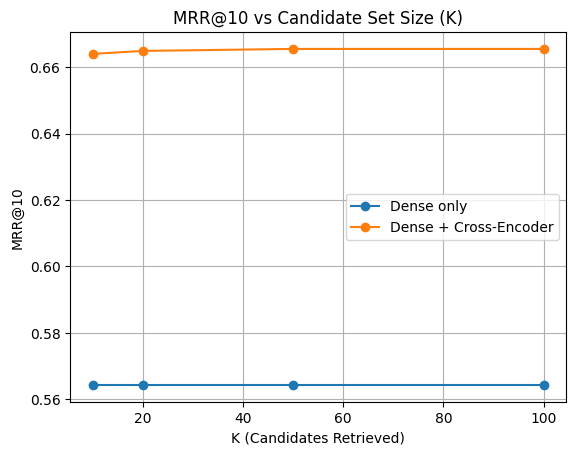

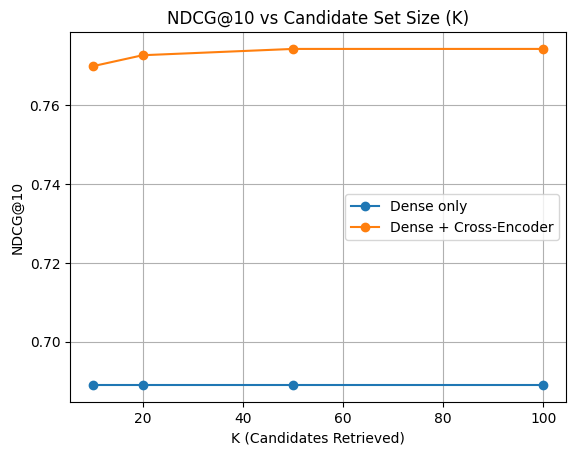

In [19]:
import matplotlib.pyplot as plt

Ks = [10, 20, 50, 100]

dense_mrr = [0.5643, 0.5643, 0.5643, 0.5643]
rerank_mrr = [0.6640, 0.6649, 0.6655, 0.6655]

dense_ndcg = [0.6890, 0.6890, 0.6890, 0.6890]
rerank_ndcg = [0.7699, 0.7727, 0.7743, 0.7743]

plt.figure()
plt.plot(Ks, dense_mrr, marker="o", label="Dense only")
plt.plot(Ks, rerank_mrr, marker="o", label="Dense + Cross-Encoder")

plt.xlabel("K (Candidates Retrieved)")
plt.ylabel("MRR@10")
plt.title("MRR@10 vs Candidate Set Size (K)")
plt.legend()
plt.grid(True)
plt.show()


plt.figure()
plt.plot(Ks, dense_ndcg, marker="o", label="Dense only")
plt.plot(Ks, rerank_ndcg, marker="o", label="Dense + Cross-Encoder")

plt.xlabel("K (Candidates Retrieved)")
plt.ylabel("NDCG@10")
plt.title("NDCG@10 vs Candidate Set Size (K)")
plt.legend()
plt.grid(True)
plt.show()
